# <center>Welcome FSP solved with diverse heuristics</center>

This notebook presents a practical approach to solving the flowshop problem by implementing well-known heuristics. These heuristics are effective in generating high-quality solutions for large instances of the problem, requiring only a reasonable amount of computational resources.

You can visit the website to test the implemented heuristics and gain a comparative insight :  https://flow-shop-problem.streamlit.app

# Table of Contents

1. [Johnson **n** jobs **2** machines](#Johnson-**n**-jobs-**2**-machines)
2. [CDS Heuristic](#cds-heuristic)
3. [NEH Heuristic](#neh-heuristic)
4. [Ham Heuristic](#ham-heuristic)
5. [Palmer Heuristic](#palmer-heuristic)
6. [PRSKE Heuristic](#prske-heuristic)
8. [Chen Heuristic](#Chen-heuristic-(1983))
7. [Weighted CDS Heuristic](#Weighted-CDS-heuristic)
9. [Gupta Heuristic](#gupta-heuristic)
10. [NRH Heuristic (NEW Ramzi Heuristic)](#nrh-heuristic-new-ramzi-heuristic)
11. [Kusiak Heuristic ](#Kusiak-heuristic)
12. [ Comparison Figure   ](#Comparison-Figure)
13. [Description of Proposed Heuristic NRH](#New-Ramzi-Heuristic-Explication)



## Data Utils

In [2]:
import numpy as np
import itertools
import time
import math
import pandas as pd
import matplotlib.pyplot as plt

In [3]:


'''
Reading the data from the benchmark file
'''

def read_flow_shop_data(file_path, machine_count, job_count):
    instances = []
    with open(file_path) as p:
        lines = p.readlines()
        line_count = len(lines)

        instance_count = line_count // (machine_count + 3)

        for i in range(instance_count):
            # recover the data of each instance
            params_line = lines[i * (machine_count + 3) + 1]
            job_count, machine_count, initial_seed, upper_bound, lower_bound = list(
                map(lambda x: int(x), params_line.split()))

            # processing_times = [list(map(int, lines[i * (machine_count + 3) + 3])) for line in lines]
            processing_times = np.array([list(map(lambda x: int(x), line.strip().split())) for
                                         line in lines[
                                                 i * (machine_count + 3) + 3:  # start
                                                 i * (machine_count + 3) + 3 + machine_count  # end
                                                 ]
                                         ])

            record = (machine_count, job_count, processing_times)
            instances.append(record)

    return instances



### Path Cost calculation function :
used to calculate the cost of current node, which is the correct cost starting for the actual path of executed jobs

In [4]:
def calculate_makespan(processing_times, sequence):
    n_jobs = len(sequence)
    n_machines = len(processing_times[0])
    end_time = [[0] * (n_machines + 1) for _ in range(n_jobs + 1)]

    for j in range(1, n_jobs + 1):
        for m in range(1, n_machines + 1):
            end_time[j][m] = max(end_time[j][m - 1], end_time[j - 1]
                                 [m]) + processing_times[sequence[j - 1]][m - 1]

    return end_time[n_jobs][n_machines]

### Gantt graph generator

In [5]:
def generate_gantt_chart(processing_times, seq, interval=50, labeled=True):
    data = processing_times.T
    nb_jobs, nb_machines = processing_times.shape
    schedules = np.zeros((nb_machines, nb_jobs), dtype=dict)
    # schedule first job alone first
    task = {"name": "job_{}".format(
        seq[0]+1), "start_time": 0, "end_time": data[0][seq[0]]}

    schedules[0][0] = task
    for m_id in range(1, nb_machines):
        start_t = schedules[m_id-1][0]["end_time"]
        end_t = start_t + data[m_id][0]
        task = {"name": "job_{}".format(
            seq[0]+1), "start_time": start_t, "end_time": end_t}
        schedules[m_id][0] = task

    for index, job_id in enumerate(seq[1::]):
        start_t = schedules[0][index]["end_time"]
        end_t = start_t + data[0][job_id]
        task = {"name": "job_{}".format(
            job_id+1), "start_time": start_t, "end_time": end_t}
        schedules[0][index+1] = task
        for m_id in range(1, nb_machines):
            start_t = max(schedules[m_id][index]["end_time"],
                          schedules[m_id-1][index+1]["end_time"])
            end_t = start_t + data[m_id][job_id]
            task = {"name": "job_{}".format(
                job_id+1), "start_time": start_t, "end_time": end_t}
            schedules[m_id][index+1] = task

    # create a new figure
    fig, ax = plt.subplots(figsize=(18, 8))

    # set y-axis ticks and labels
    y_ticks = list(range(len(schedules)))
    y_labels = [f'Machine {i+1}' for i in y_ticks]
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_labels)

    # calculate the total time
    total_time = max([job['end_time'] for proc in schedules for job in proc])

    # set x-axis limits and ticks
    ax.set_xlim(0, total_time)
    x_ticks = list(range(0, total_time+1, interval))
    ax.set_xticks(x_ticks)

    # set grid lines
    ax.grid(True, axis='x', linestyle='--')

    # create a color dictionary to map each job to a color
    color_dict = {}
    for proc in schedules:
        for job in proc:
            if job['name'] not in color_dict:
                color_dict[job['name']] = (np.random.uniform(
                    0, 1), np.random.uniform(0, 1), np.random.uniform(0, 1))

    # plot the bars for each job on each processor
    for i, proc in enumerate(schedules):
        for job in proc:
            start = job['start_time']
            end = job['end_time']
            duration = end - start
            color = color_dict[job['name']]
            ax.barh(i, duration, left=start, height=0.5,
                    align='center', color=color, alpha=0.8)
            if labeled:
                # add job labels
                label_x = start + duration/2
                label_y = i
                ax.text(
                    label_x, label_y, job['name'][4:], ha='center', va='center', fontsize=10)

    plt.show()

## Heuristics

### Johnson **n** jobs **2** machines

In [6]:
def johnson_method(processing_times):
    jobs, machines = processing_times.shape
    copy_processing_times = processing_times.copy()
    maximum = processing_times.max() + 1
    m1 = []
    m2 = []

    if machines != 2:
        raise Exception("Johson method only works with two machines")

    for i in range(jobs):
        minimum = copy_processing_times.min()
        position = np.where(copy_processing_times == minimum)

        if position[1][0] == 0:
            m1.append(position[0][0])
        else:
            m2.insert(0, position[0][0])

        copy_processing_times[position[0][0]] = maximum

    return m1+m2

### Test Johnson

In [7]:
# Generate a random example to work with 7 jobs and 2 machines
rnd_data = np.random.randint(size=(7,2), low=5, high=23)
print(rnd_data, "\n")

start_time = time.time()
sol = johnson_method(rnd_data)
elapsed_time = time.time() - start_time

print(f'Best sequence found by Johnson is {sol} with a makespan of {calculate_makespan(rnd_data,sol)}')
print("Elapsed time:", elapsed_time, "seconds")

[[20 16]
 [ 6 22]
 [12 21]
 [ 6  7]
 [20 19]
 [19 12]
 [14  7]] 

Best sequence found by Johnson is [1, 3, 2, 4, 0, 5, 6] with a makespan of 110
Elapsed time: 0.0009992122650146484 seconds


### CDS Heuristic [Campbell,Dudek and Smith ] : **n** jobs **m** machines (1970)

In [8]:
# python code for CDS heuristic

def cds_heuristic(processing_times):
    processing_times = processing_times.T
    nb_machines, nb_jobs = processing_times.shape

    best_cost = math.inf

    machine_1_times = np.zeros((nb_jobs, 1))
    machine_2_times = np.zeros((nb_jobs, 1))

    # iterate through the nb_machines-1 auxiliary n-job 2-machines problems

    for k in range(nb_machines - 1):
        machine_1_times[:, 0] += processing_times[:][k]
        machine_2_times[:, 0] += processing_times[:][-k-1]

        jn_times = np.concatenate((machine_1_times, machine_2_times), axis=1)
        seq = johnson_method(jn_times)
        cost = calculate_makespan(jn_times, seq)
        if cost < best_cost:
            best_cost = cost
            best_seq = seq

    return best_seq, calculate_makespan(processing_times.T, best_seq)


### Test CDS

In [9]:
rnd_data = np.random.randint(size=(8,5), low=10, high=50)
print(rnd_data, "\n")
cds_heuristic(rnd_data.T)
    


[[35 13 33 29 39]
 [39 29 38 35 20]
 [23 19 17 44 43]
 [31 33 44 24 19]
 [16 27 44 15 33]
 [12 34 14 29 17]
 [40 14 36 14 25]
 [37 18 24 49 11]] 



([1, 3, 0, 2, 4], 350)

In [10]:
start_time = time.time()
best_solution, best_cost  = cds_heuristic(benchmarks[0])

end_time = time.time()

elapsed_time = end_time - start_time

print(f'Results of CDS:')
print(f'Best sequence is {best_solution} with a makespan of {best_cost}.')
print(f'Elapsed time of {elapsed_time} seconds.')

NameError: name 'benchmarks' is not defined

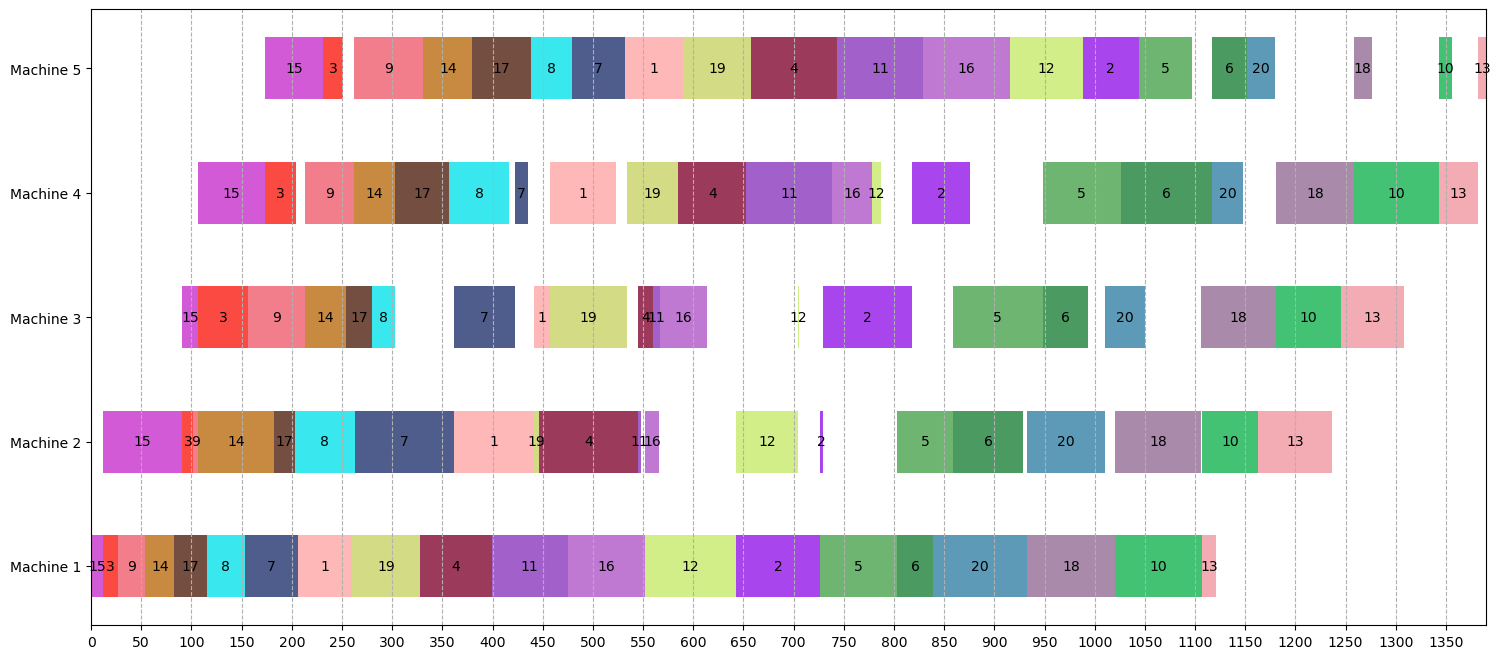

In [ ]:
generate_gantt_chart(benchmarks[0],best_solution )

### NEH Algorithm

In [ ]:

def _order_jobs_in_descending_order_of_total_completion_time(processing_times):
    total_completion_time = processing_times.sum(axis=1)
    return np.argsort(total_completion_time, axis=0).tolist()

In [ ]:
def _insertion(sequence, position, value):
    new_seq = sequence[:]
    new_seq.insert(position, value)
    return new_seq

In [ ]:
def neh_algorithm(processing_times):
    ordered_sequence = _order_jobs_in_descending_order_of_total_completion_time(
        processing_times)
    # Define the initial order
    J1, J2 = ordered_sequence[:2]
    sequence = [J1, J2] if calculate_makespan(processing_times, [
        J1, J2]) < calculate_makespan(processing_times, [J2, J1]) else [J2, J1]
    del ordered_sequence[:2]
    # Add remaining jobs
    for job in ordered_sequence:
        Cmax = float('inf')
        best_sequence = []
        for i in range(len(sequence)+1):
            new_sequence = _insertion(sequence, i, job)
            Cmax_eval = calculate_makespan(processing_times, new_sequence)
            if Cmax_eval < Cmax:
                Cmax = Cmax_eval
                best_sequence = new_sequence
        sequence = best_sequence
    return sequence, Cmax

In [ ]:
start_time = time.time()
best_solution,best_cost  = neh_algorithm(instances[6][2].T)

end_time = time.time()

elapsed_time = end_time - start_time

print(f'Results of CDS:')
print(f'Best sequence is {best_solution} with a makespan of {best_cost}.')
print(f'Elapsed time of {elapsed_time} seconds.')


Results of NEH:
Best sequence is [8, 6, 15, 10, 7, 1, 16, 2, 14, 13, 17, 3, 9, 11, 0, 18, 5, 4, 12, 19] with a makespan of 1334.
Elapsed time of 0.007998943328857422 seconds.


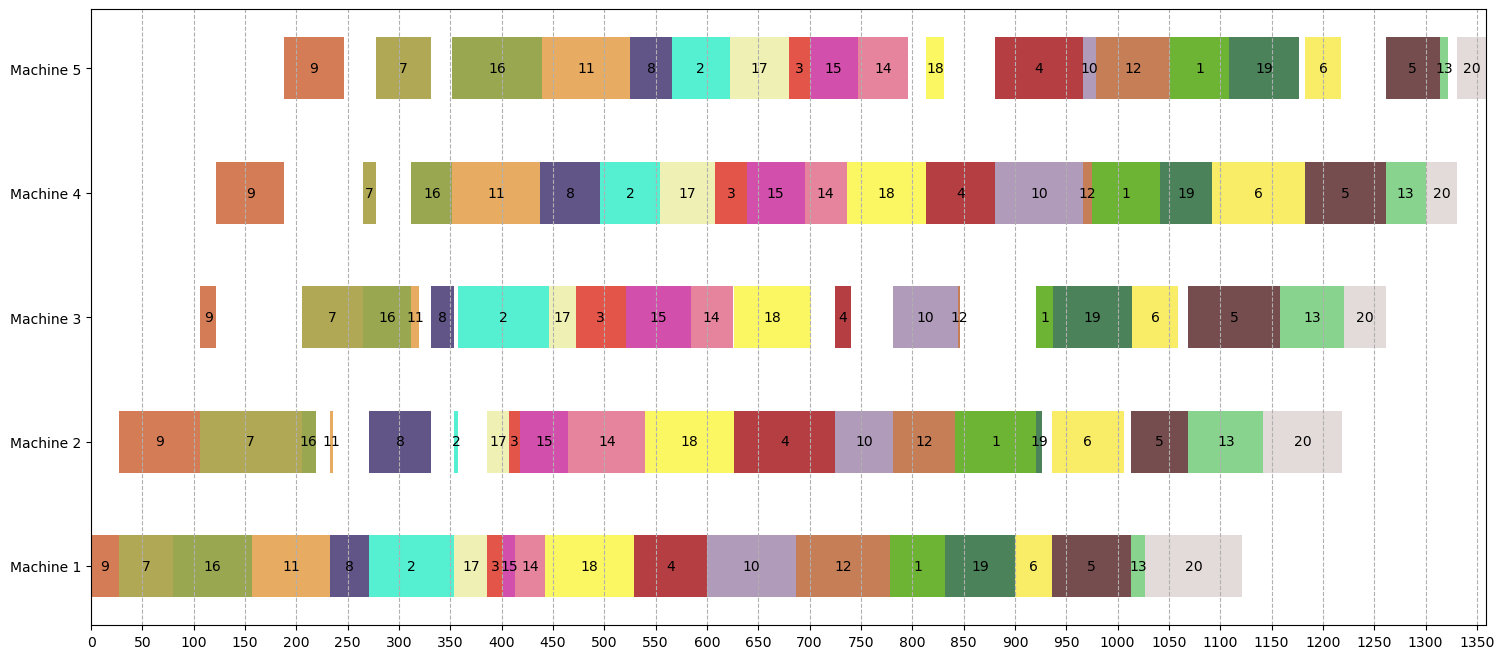

In [ ]:
generate_gantt_chart(benchmarks[0],best_solution )

In [ ]:
from utils.benchmarks import benchmarks

In [ ]:
def _ham_sol_1(Pi1: np.ndarray, Pi2: np.ndarray) -> list:
    diff = Pi2 - Pi1
    sol = np.argsort(diff, axis=0).tolist()
    sol.reverse()       # in decreasing order
    return sol

In [ ]:
def _ham_sol_2(Pi1: np.ndarray, Pi2: np.ndarray) -> list:

    diff = Pi2 - Pi1

    Pi1_index = [(x, i) for i, x in enumerate(Pi1) if diff[i] >= 0]
    Pi2_index = [(x, i) for i, x in enumerate(Pi2) if diff[i] < 0]

    Pi1_sorted = sorted(Pi1_index, key=lambda x: x[0])
    Pi2_sorted = sorted(Pi2_index, key=lambda x: x[0], reverse=True)

    Pi1_list = [i for _, i in Pi1_sorted]
    Pi2_list = [i for _, i in Pi2_sorted]

    return Pi1_list + Pi2_list

In [ ]:
def ham_heuristic(processing_times: np.ndarray) -> list:
    _, m = processing_times.shape
    left = processing_times[:, :int(m/2)]
    right = processing_times[:, int(m/2):]

    Pi1 = left.sum(axis=1)
    Pi2 = right.sum(axis=1)

    solution1 = _ham_sol_1(Pi1, Pi2)
    solution2 = _ham_sol_2(Pi1, Pi2)
    Cmax1 = calculate_makespan(processing_times, solution1)
    Cmax2 = calculate_makespan(processing_times, solution2)

    if Cmax1 < Cmax2:
        return solution1, Cmax1
    else:
        return solution2, Cmax2

### TEST HAM

In [ ]:
start_time = time.time()
best_solution, best_cost  = ham_heuristic(benchmarks[6])

end_time = time.time()

elapsed_time = end_time - start_time

print(f'Results of HAM:')
print(f'Best sequence is {best_solution} with a makespan of {best_cost}.')
print(f'Elapsed time of {elapsed_time} seconds.')

Results of HAM:
Best sequence is [2, 8, 16, 14, 18, 10, 1, 12, 15, 7, 13, 5, 0, 4, 9, 17, 3, 6, 19, 11] with a makespan of 1417.
Elapsed time of 0.0 seconds.


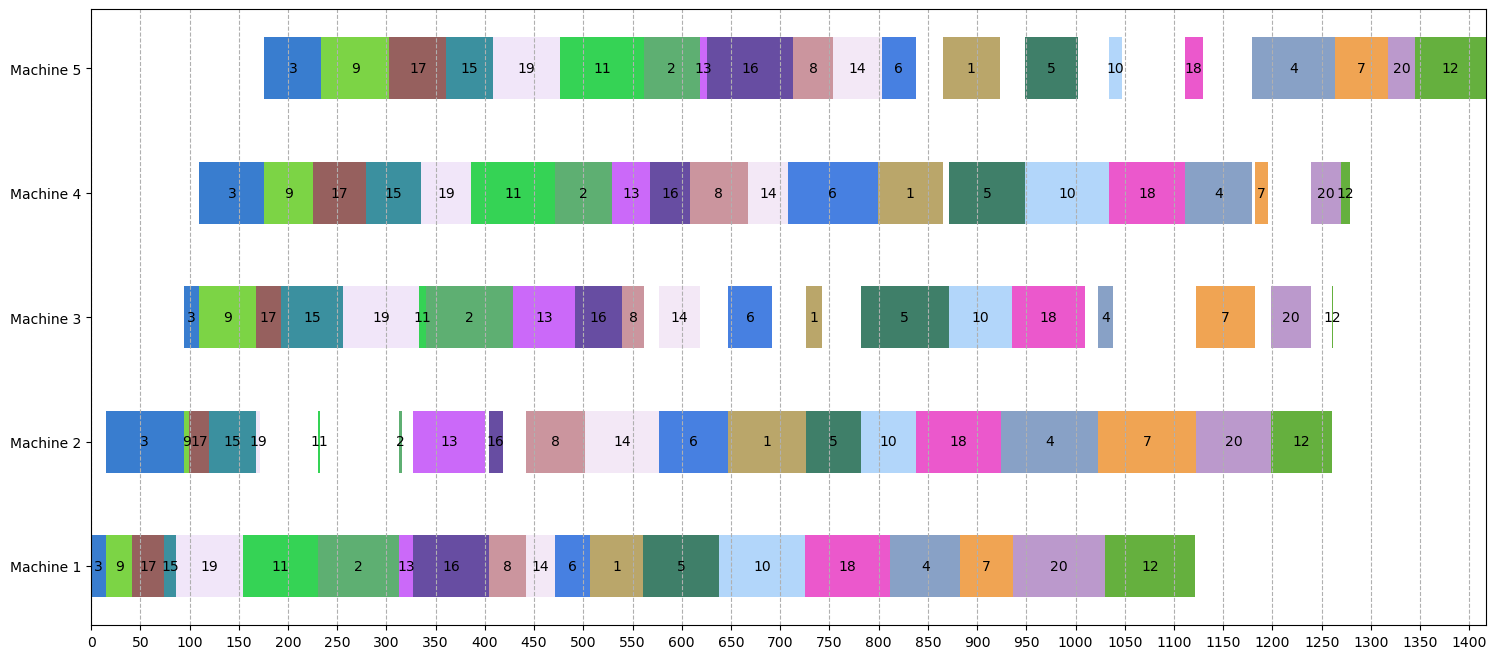

In [ ]:
generate_gantt_chart(benchmarks[0],best_solution )

## Palmer Heuristic

In [ ]:
def _init_weights(nb_machines):
    lst = np.array([(2*i - 1 - nb_machines) for i in range(nb_machines)])
    return lst - np.mean(lst)


def _compute_weighted_sum(dist_mat, weights, nb_jobs, nb_machines):
    # Adjusted to work with dist_mat having dimensions [nb_jobs, nb_machines]
    weighted_sum = []
    for i in range(nb_jobs):
        somme = np.dot(dist_mat[i, :], weights)
        weighted_sum.append(somme)
    return np.array(weighted_sum)


def run_palmer(dist_mat):
    nb_jobs, nb_machines = dist_mat.shape
    weights = _init_weights(nb_machines)

    weighted_sum = _compute_weighted_sum(
        dist_mat, weights, nb_jobs, nb_machines)
    ordre_opt = np.argsort(weighted_sum)[::-1]

    makespan = calculate_makespan(dist_mat, ordre_opt)

    return ordre_opt, makespan

### PALMER Test

In [ ]:
start_time = time.time()
result , makespan = run_palmer(benchmarks[0])

end_time = time.time()

elapsed_time = end_time - start_time

print(f'Results of Palmer:')
print(f'Best sequence is {result} \nwith a makespan of {makespan}.')
print(f'Elapsed time of {elapsed_time} seconds.')

Results of Palmer:
Best sequence is [ 8 10 16 14 15 18  2  5 13  7  1  3  0  4 12  6 11  9 17 19] 
with a makespan of 1384.
Elapsed time of 0.0010035037994384766 seconds.


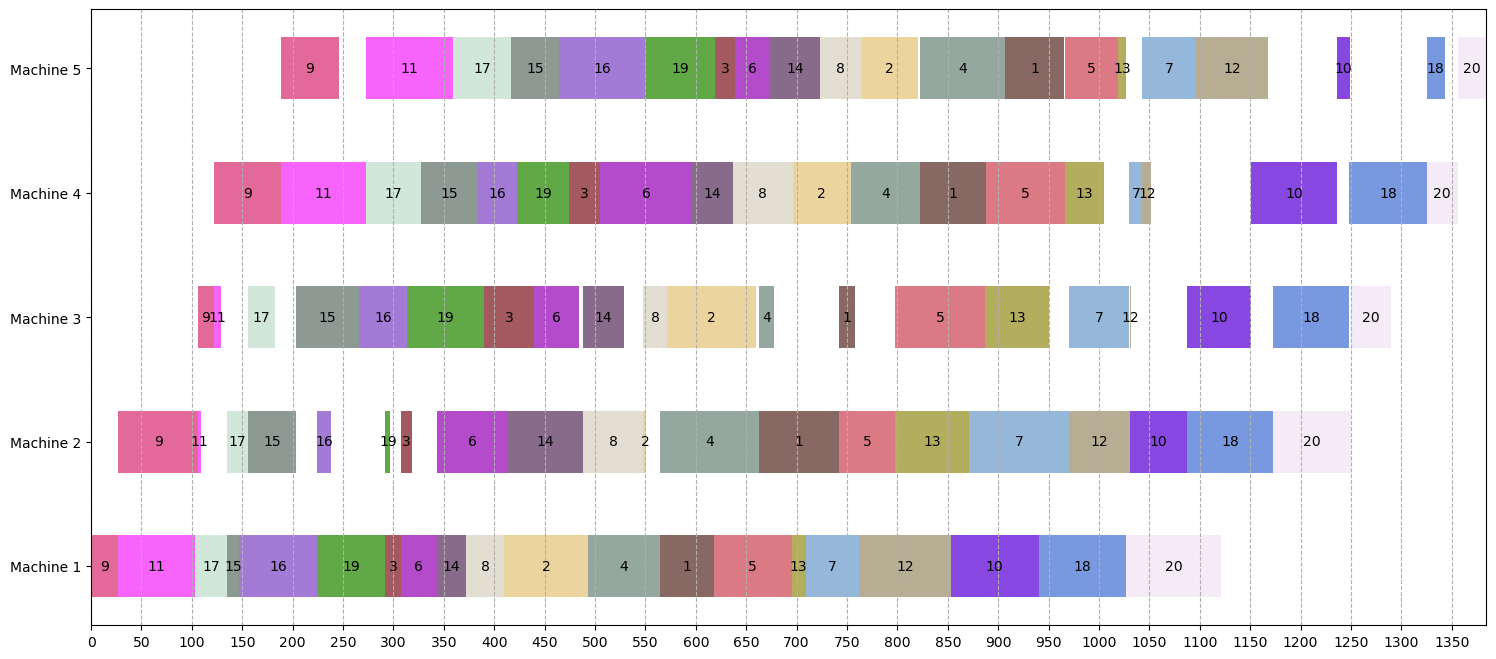

In [ ]:
generate_gantt_chart(benchmarks[0], result)

## PRSKE Heuristic

In the new PRSKE priority rule, all jobs are ordered by the non-increasing sum of : $$ AVG_i + STD_i + |SKE_i|$$ 
where:

- $ AVG_i $ represents the average processing time of job _i_.
- $ STD_i $ stands for the standard deviation of job _i_.
- $ |SKE_i| $ denotes the absolute value of the skewness of job _i_.

The parameters are defined as follows:

- $$ AVG_i = \frac{1}{m} \sum_{k=1}^{m} t_{i,k}$$
- $$ STD_i = \sqrt{\frac{1}{m-1} \sum_{k=1}^{m} (t_{i,k} - AVG_i)^2} $$
- $$ SKE_i = \frac{\frac{1}{m} \sum_{k=1}^{m} (t_{i,k} - AVG_i)^3}{\left({\sqrt{\frac{1}{m} \sum_{k=1}^{m} (t_{i,k} - AVG_i)^2}}\right)^3} $$

where:

- $ t_{i,k} $ represents the processing time of job _i_ on machine _k_.
- $ m $ is the number of machines.



In [ ]:
def _AVG(processing_times):
    return np.mean(processing_times, axis=1)


In [ ]:
def _STD(processing_times):
    return np.std(processing_times, axis=1, ddof=1)

In [ ]:

def _skewness_SKE(processing_times):
    """
    Calculates the skewness of job processing times across machines.
    Return : Skewness values for each job

    """
    num_jobs, num_machines = processing_times.shape
    skewness_values = []

    for i in range(num_jobs):
        avg_processing_time = np.mean(processing_times[i, :])
        numerateur = 0
        denominateur = 0

        for j in range(num_machines):
            som = (processing_times[i, j] - avg_processing_time)
            numerateur += som ** 3
            denominateur += som ** 2

        numerateur *= (1 / num_machines)
        denominateur = (np.sqrt(denominateur * (1 / num_machines))) ** 3

        skewness_values.append(numerateur / denominateur)

    return np.array(skewness_values)

In [ ]:
def PRSKE(processing_times):
    """
    Calculates the job sequence based on the PRSKE priority rule

    """
    avg = _AVG(processing_times)   # Calculate average processing times

    # Calculate standard deviation processing times
    std = _STD(processing_times)

    skw = _skewness_SKE(processing_times)  # Calculate Skewness

    order = skw + std + avg

    # Sort in descending order
    sorted_order = sorted(
        zip(order, list(range(processing_times.shape[0]))), reverse=True)

    sequence = [job for _, job in sorted_order]

    makespan = calculate_makespan(processing_times, sequence)

    return sequence,  makespan

### TEST PRSKE

In [ ]:
start_time = time.time()
best_solution, best_cost  = PRSKE(benchmarks[0])

end_time = time.time()

elapsed_time = end_time - start_time

print(f'Results of PRSKE:')
print(f'Best sequence is {best_solution} \n with a makespan of {best_cost}.')
print(f'Elapsed time of {elapsed_time} seconds.')

Results of PRSKE:
Best sequence is [3, 17, 10, 1, 9, 11, 6, 4, 19, 15, 18, 5, 0, 12, 8, 13, 14, 7, 16, 2] 
 with a makespan of 1593.
Elapsed time of 0.0 seconds.


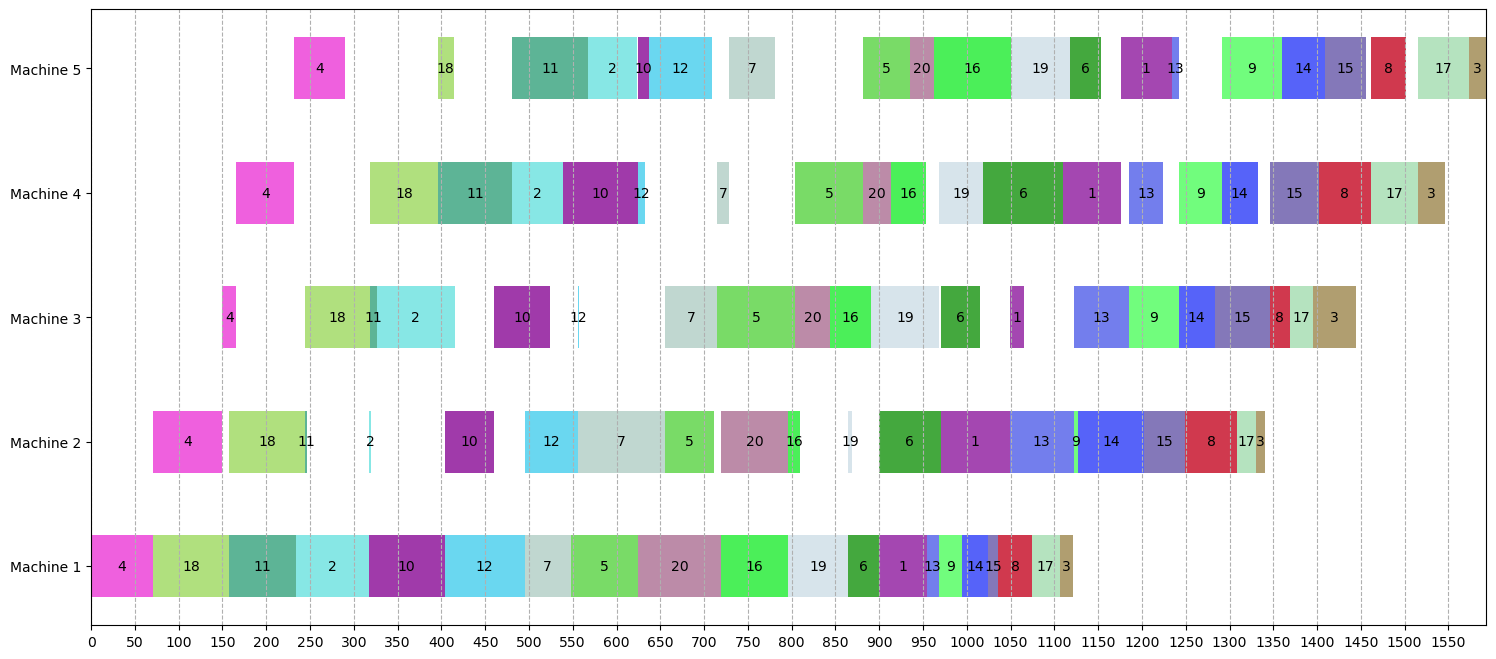

In [ ]:
generate_gantt_chart(benchmarks[0],best_solution )

## CHEN Heuristic (1983)

Chen (1983) propose une heuristique qui consiste à procéder de la manière suivante :

- on calcule la somme de temps opératoires $ S(i) $  pour chaque tâche i avec :
$$ S(i) = \sum_{k=1}^{m} t_{i,k} $$
- on trouve la tâche c qui a la $ S(i) $ la plus importante et on enlève cette tâche de l'ensemble de tâches non ordonnancées.
- on ordonnance les tâches qui ont $ P_{i1} <= P_{im} $ dans l'ordre croissant de $ P_{i1} $ et on obtient un ordonnancement partiel $ SA $.
- on ordonnance les tâches qui ont $ P_{i1}>P_{im} $ dans l'ordre décroissant de $ P_{im} $ et on obtient un ordonnancement partiel $ SB $ .
- on retient comme solution finale l'ordonnancement $ (SA, c, SB) $

In [ ]:
def chen_heuristic(processing_times):

    num_jobs = processing_times.shape[0]

    # Calcule de la somme de temps opératoires S(i) pour chaque tâche i
    sum_processing_times = [sum(processing_times[i]) for i in range(num_jobs)]

    job_max_sum = max(sum_processing_times)
    job_c = sum_processing_times.index(job_max_sum)

    remaining_jobs = [i for i in range(num_jobs) if i != job_c]

    sorted_jobs_le = sorted(
        remaining_jobs, key=lambda i: processing_times[i][0])

    sorted_jobs_gt = sorted(
        remaining_jobs, key=lambda i: processing_times[i][-1], reverse=True)

    S_a = [i for i in sorted_jobs_le if processing_times[i]
           [0] <= processing_times[i][-1]]
    S_b = [i for i in sorted_jobs_gt if processing_times[i]
           [0] > processing_times[i][-1]]

    sequence = S_a + [job_c] + S_b

    makespan = calculate_makespan(processing_times, sequence)

    return sequence, makespan

### Test Chen heuristic

In [ ]:
start_time = time.time()

best_solution, best_cost  = chen_heuristic(benchmarks[0])

end_time = time.time()

elapsed_time = end_time - start_time

print(f'Results of CHEN:')
print(f'Best sequence is {best_solution} \n with a makespan of {best_cost}.')
print(f'Elapsed time of {elapsed_time} seconds.')

Results of CHEN:
Best sequence is [14, 2, 8, 13, 16, 7, 6, 0, 18, 3, 10, 15, 4, 11, 1, 5, 19, 17, 9, 12] 
 with a makespan of 1390.
Elapsed time of 0.0 seconds.


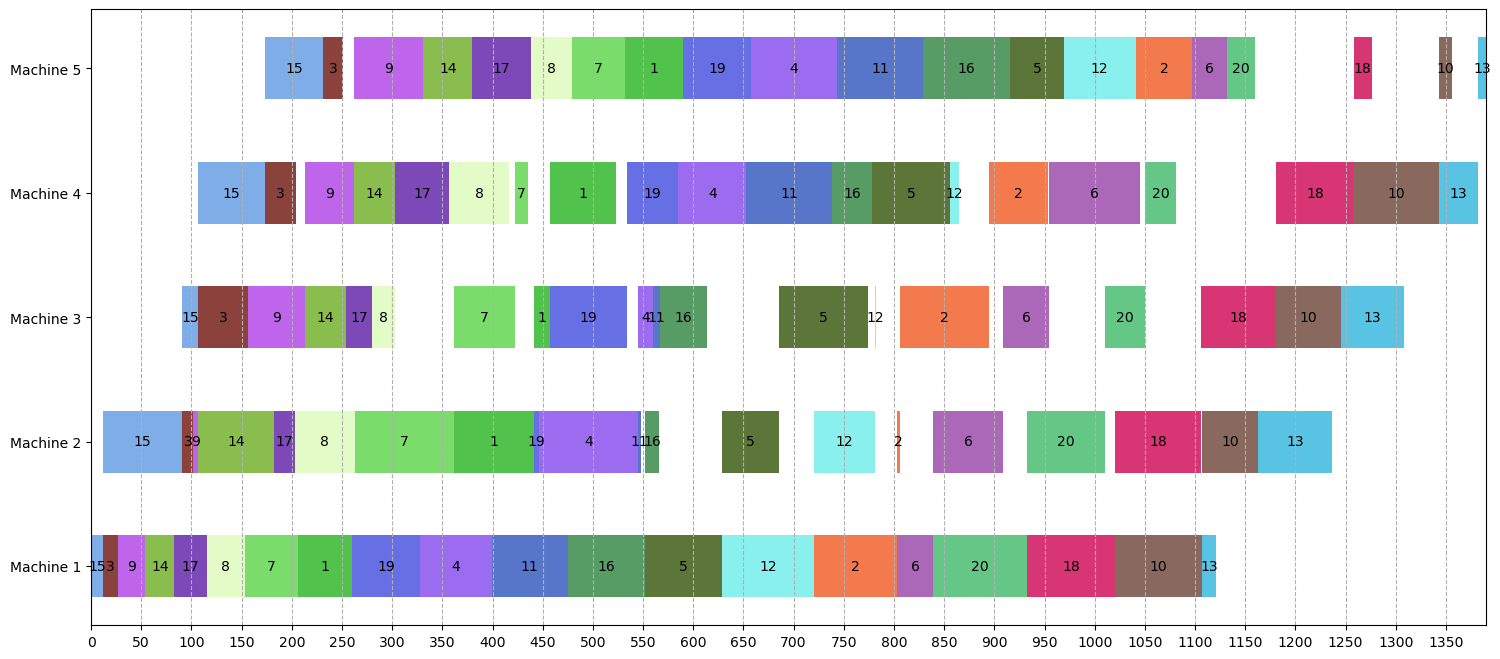

In [ ]:
generate_gantt_chart(benchmarks[0],best_solution )

## Weighted CDS Heuristic

In [ ]:
def _johnsons_rule(machine1, machine2):
    artificial_jobs = list(zip(machine1, machine2))

    jobs_sorted = sorted(enumerate(artificial_jobs), key=lambda x: min(x[1]))
    U = [job for job in jobs_sorted if job[1][0] < job[1][1]]
    V = [job for job in jobs_sorted if job[1][0] >= job[1][1]]

    sequence = [job[0] for job in U] + [job[0] for job in reversed(V)]
    return sequence

In [ ]:
def weighted_csd(processing_times):
    _, n_machines = processing_times.shape
    best_sequence = None
    best_makespan = float('inf')

    for k in range(1, n_machines - 1):
        weights_front = np.array([n_machines - i for i in range(k)])
        weights_back = np.array([i + 1 for i in range(k, n_machines)])
        AM1 = processing_times[:, :k].dot(weights_front)
        AM2 = processing_times[:, k:].dot(weights_back)

        sequence = _johnsons_rule(AM1, AM2)
        makespan = calculate_makespan(processing_times, sequence)
        if makespan < best_makespan:
            best_makespan = makespan
            best_sequence = sequence

    return best_sequence, makespan

### Weighted CDS Heuristic TEST

In [ ]:
start_time = time.time()

best_solution, best_cost = weighted_csd(benchmarks[0])

end_time = time.time()

elapsed_time = end_time - start_time

print(f'Results of GUPTA:')
print(f'Best sequence is {best_solution} \n with a makespan of {best_cost}.')
print(f'Elapsed time of {elapsed_time} seconds.')

Results of GUPTA:
Best sequence is [14, 12, 2, 8, 13, 16, 5, 7, 6, 0, 18, 3, 10, 4, 15, 1, 9, 17, 11, 19] 
 with a makespan of 1381.
Elapsed time of 0.0010020732879638672 seconds.


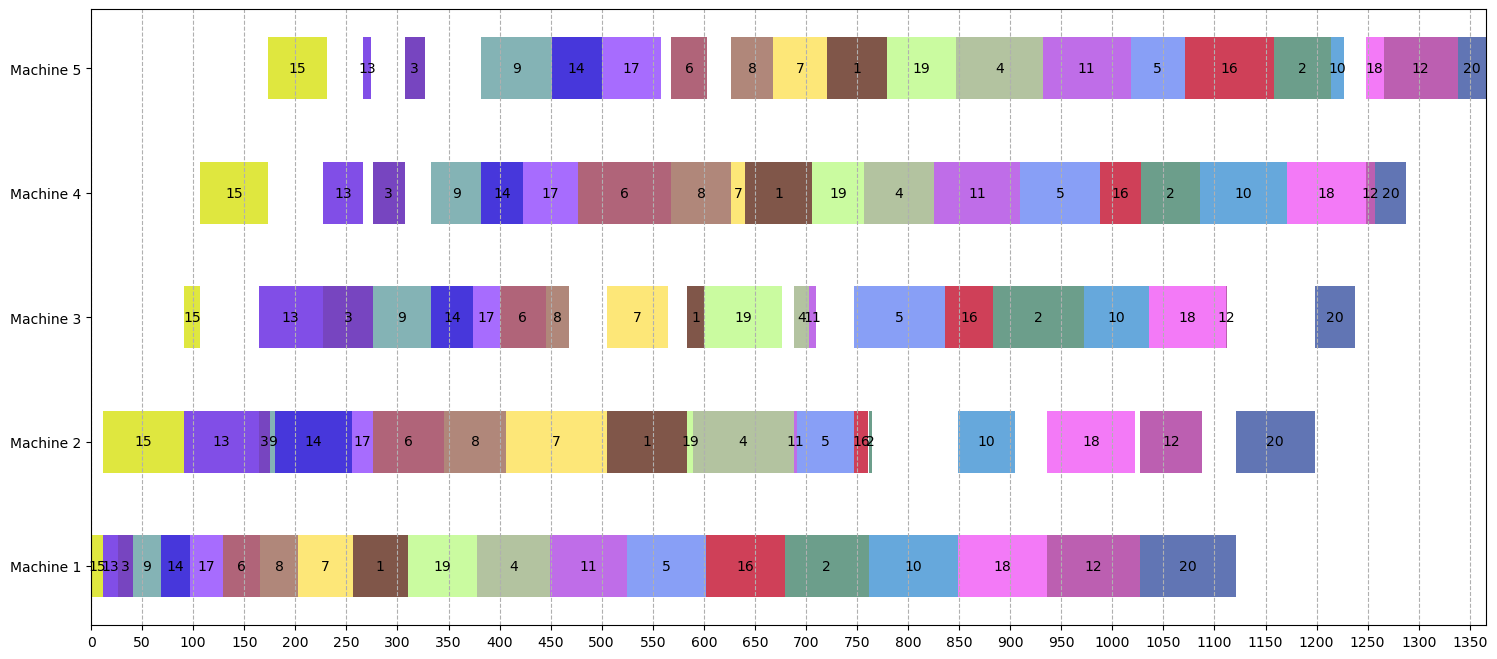

In [ ]:
generate_gantt_chart(benchmarks[0],best_solution )

## Gupta Heuristic

In [ ]:
def _min_sum_processing(job_index, processing_times):
    min_sum = np.inf
    for i in range(processing_times.shape[1] - 1):
        sum_for_pair = processing_times[job_index,
                                        i] + processing_times[job_index, i + 1]
        if sum_for_pair < min_sum:
            min_sum = sum_for_pair
    return min_sum


In [ ]:
def _calculate_priority(job_index, processing_times):
    diff = float(processing_times[job_index, 0] -
                 processing_times[job_index, -1])
    sign = (diff > 0) - (diff < 0)
    return sign / _min_sum_processing(job_index, processing_times)

In [ ]:

def gupta_heuristic(processing_times):
    priorities = [_calculate_priority(i, processing_times)
                  for i in range(processing_times.shape[0])]
    total_times = [np.sum(processing_times[i])
                   for i in range(processing_times.shape[0])]
    sequence = sorted(range(len(priorities)), key=lambda k: (
        priorities[k], total_times[k]))
    return sequence, calculate_makespan(processing_times, sequence)

### GUPTA TEST

In [ ]:
start_time = time.time()

best_solution, best_cost  = gupta_heuristic(benchmarks[0])

end_time = time.time()

elapsed_time = end_time - start_time

print(f'Results of GUPTA:')
print(f'Best sequence is {best_solution} \n with a makespan of {best_cost}.')
print(f'Elapsed time of {elapsed_time} seconds.')

Results of GUPTA:
Best sequence is [10, 2, 8, 16, 14, 15, 7, 13, 0, 3, 18, 6, 4, 5, 9, 17, 1, 19, 12, 11] 
 with a makespan of 1396.
Elapsed time of 0.0 seconds.


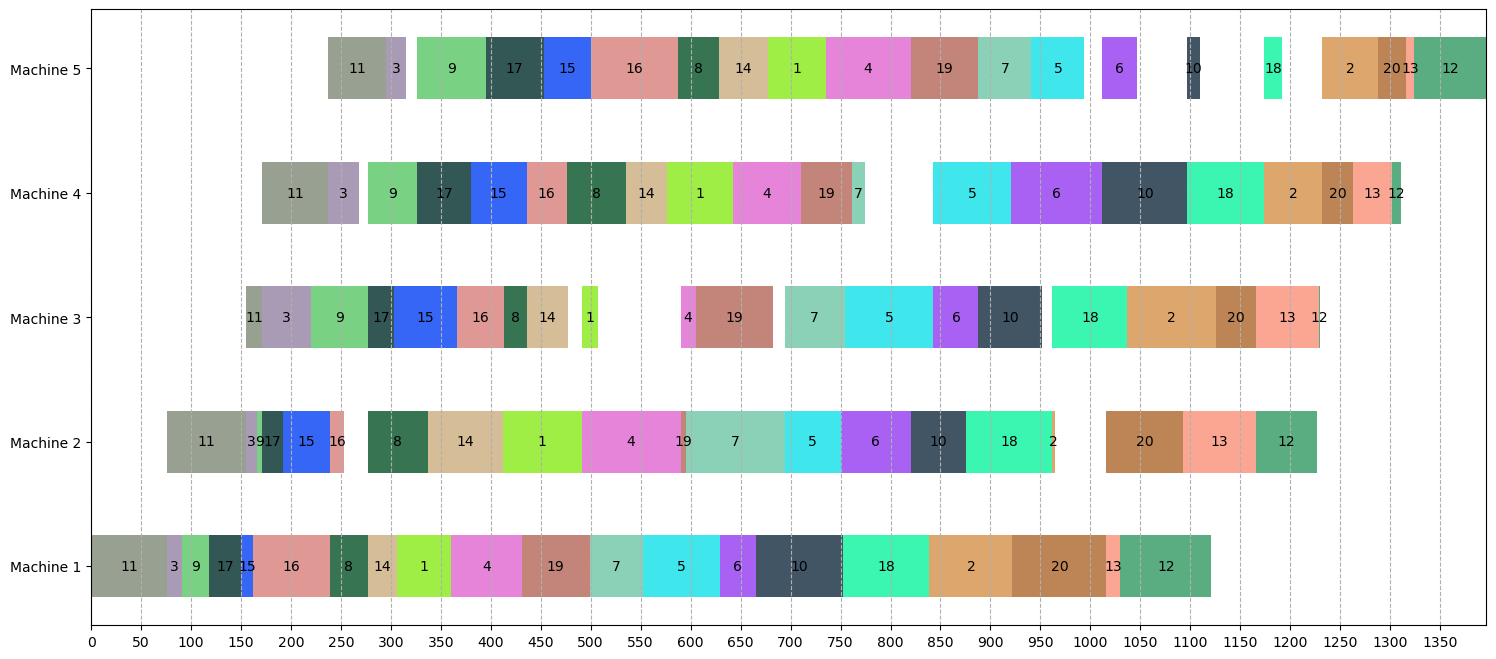

In [ ]:
generate_gantt_chart(benchmarks[0],best_solution )

## NRH Heuristic (NEW Ramzi Heuristic)

In [ ]:
def order_jobs_in_descending_order_of_decayed_completion_time(processing_times, alpha=1):
    transformed = np.vectorize(
        lambda x, y: processing_times[x, y] / np.exp(-y * alpha))(*np.indices(processing_times.shape))
    total_completion_time = transformed.sum(axis=1)

    return np.argsort(total_completion_time, axis=0).tolist()


In [ ]:
def NRH(processing_times, alpha=1):
    ordered_sequence = order_jobs_in_descending_order_of_decayed_completion_time(
        processing_times, alpha=alpha)

    # Define the initial order
    J1, J2 = ordered_sequence[:2]
    sequence = [J1, J2] if calculate_makespan(processing_times, [
        J1, J2]) < calculate_makespan(processing_times, [J2, J1]) else [J2, J1]
    del ordered_sequence[:2]
    # Add remaining jobs
    for job in ordered_sequence:
        Cmax = float('inf')
        best_sequence = []
        for i in range(len(sequence)+1):
            new_sequence = _insertion(sequence, i, job)
            Cmax_eval = calculate_makespan(processing_times, new_sequence)
            if Cmax_eval < Cmax:
                Cmax = Cmax_eval
                best_sequence = new_sequence
        sequence = best_sequence
    return sequence, Cmax

### NRH TEST

In [ ]:
start_time = time.time()

best_solution, best_cost = NRH(benchmarks[0])

end_time = time.time()

elapsed_time = end_time - start_time

print(f'Results of NRH:')
print(f'Best sequence is {best_solution} \n with a makespan of {best_cost}.')
print(f'Elapsed time of {elapsed_time} seconds.')

Results of NRH:
Best sequence is [10, 14, 3, 15, 18, 16, 5, 4, 0, 2, 12, 11, 1, 13, 8, 7, 17, 9, 6, 19] 
 with a makespan of 1305.
Elapsed time of 0.008998632431030273 seconds.


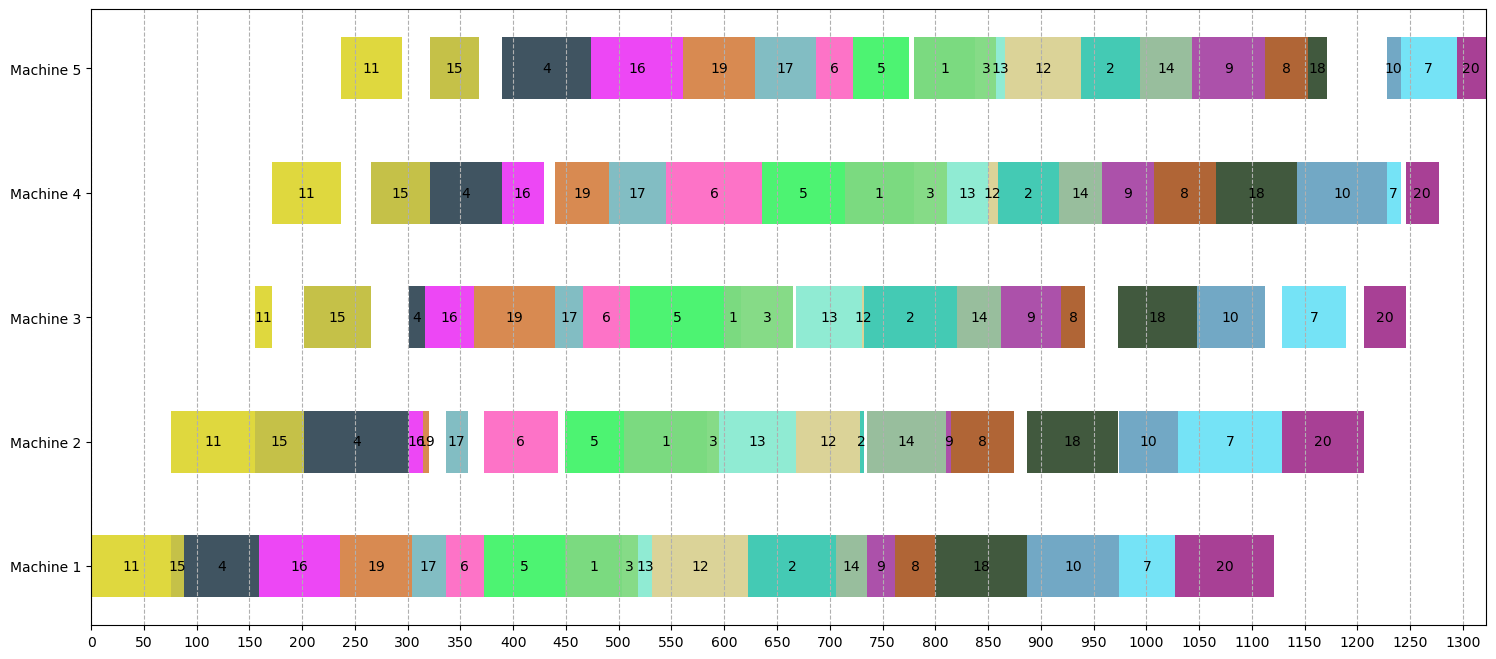

In [ ]:
generate_gantt_chart(benchmarks[0],best_solution )

## Kusiak Heuristic

In [ ]:
def kusiak(flowshop):
    """
    Kusiak algorithm for the flowshop scheduling problem.

    Parameters:
        flowshop (numpy.ndarray): Flowshop matrix where rows represent jobs and columns represent machines.

    Returns:
        numpy.ndarray: Sequence of jobs in the optimal order.
    """
    num_jobs, num_machines = flowshop.shape

    # Calculate initial completion times for each job on each machine
    completion_times = np.zeros((num_jobs, num_machines))
    for i in range(num_jobs):
        completion_times[i][0] = flowshop[i][0]
    for j in range(1, num_machines):
        completion_times[0][j] = completion_times[0][j-1] + flowshop[0][j]
    for i in range(1, num_jobs):
        for j in range(1, num_machines):
            completion_times[i][j] = max(completion_times[i-1][j], completion_times[i][j-1]) + flowshop[i][j]

    # Create a list of jobs
    jobs = list(range(num_jobs))

    # Sort jobs based on the total completion time across machines
    jobs.sort(key=lambda job: sum(completion_times[job, :]))

    # Convert the sorted job list to numpy array for easy indexing
    sorted_jobs = np.array(jobs)
    
    makespan = calculate_makespan(flowshop,sorted_jobs)

    return sorted_jobs, makespan


### Kusiak Test

In [ ]:
start_time = time.time()

best_sequence, makespan = kusiak(benchmarks[6])

end_time = time.time()

elapsed_time = end_time - start_time

print(f'Results of Kusiak:')
# print(f'Best sequence is {best_solution} \n with a makespan of {calculate_makespan(benchmarks[0], best_sequence)}.')
print(f'Best sequence is {best_sequence} \n with a makespan of {makespan}.')
print(f'Elapsed time of {elapsed_time} seconds.')

Results of Kusiak:
Best sequence is [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] 
 with a makespan of 1528.
Elapsed time of 0.0 seconds.


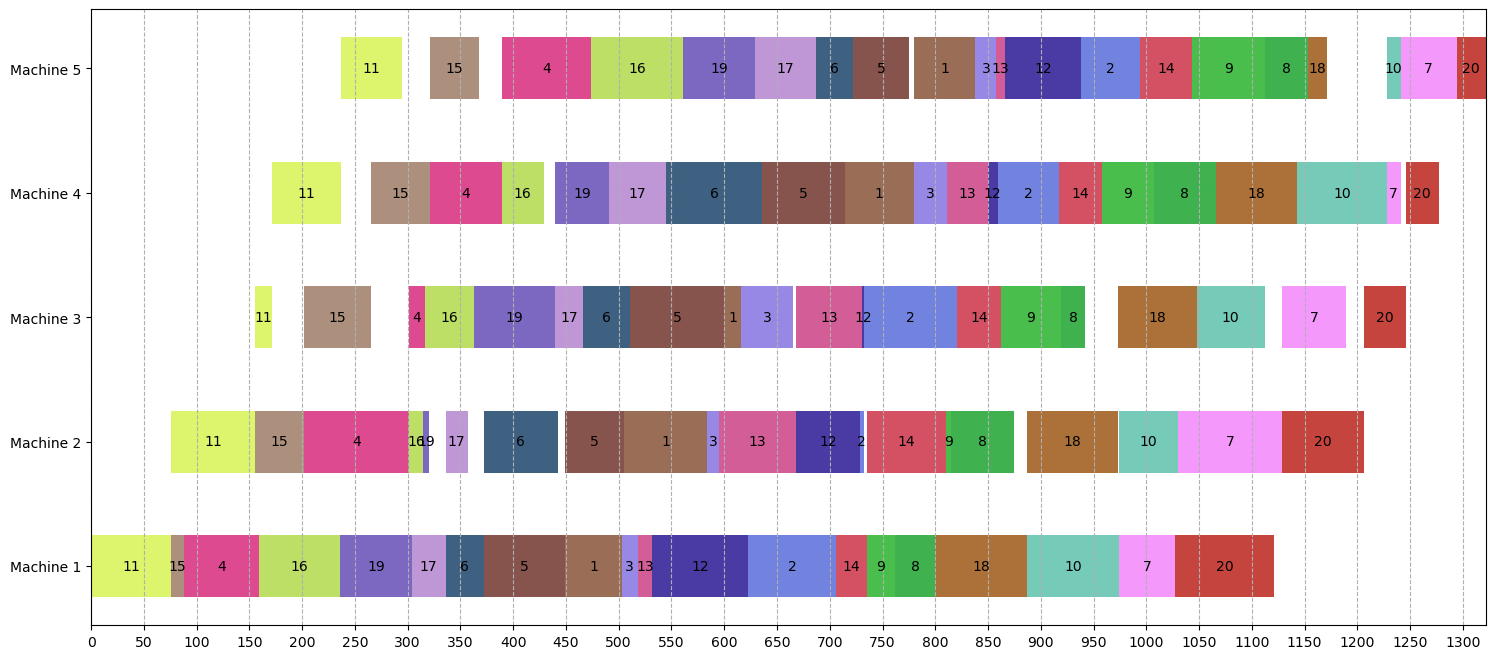

In [ ]:
generate_gantt_chart(benchmarks[0],best_solution )

## Comparison Figure

In [ ]:
def run_all_algo(processing_times, upper_bound):
    heuristics = []
    heuristics.append(('NEH', neh_algorithm(processing_times)))
    heuristics.append(('CDS', cds_heuristic(processing_times.T)))
    heuristics.append(('PRSKE', PRSKE(processing_times)))
    heuristics.append(('CHEN', chen_heuristic(processing_times)))
    heuristics.append(('NRH', NRH(processing_times)))
    heuristics.append(('Weighted_CDS', weighted_csd(processing_times)))
    heuristics.append(('GUPTA', gupta_heuristic(processing_times)))
    heuristics.append(('HAM', ham_heuristic(processing_times)))
    heuristics.append(('Palmer', run_palmer(processing_times)))
    heuristics.append(('Kusiak', kusiak(processing_times)))
   

    
    result = []
    for name, heuristic in heuristics:
        stat = []
        start_time = time.perf_counter()
        par1, par2 = heuristic
        end_time = time.perf_counter()
        elapsed_time = (end_time - start_time) * 1e6
        RDP = (( par2 - upper_bound )/ upper_bound ) * 100
        stat = (name, RDP, elapsed_time)
        result.append(stat)
        
    return result

In [ ]:
def generate_histogram(tab_stats):

    RDP = [stat[1] for stat in tab_stats]
    Execution_time = [stat[2] for stat in tab_stats]

    fig, ax = plt.subplots(figsize=(18, 10))

    index = np.arange(len(tab_stats))
    bar_width = 0.35

    rects1 = ax.bar(index, RDP, bar_width,
                    color='#D9731A',
                    label='RDP')

    rects2 = ax.bar(index + bar_width, Execution_time, bar_width,
                    color='#2A2359',
                    label='Execution Time')

    ax.set_xlabel('Heuristics')
    ax.set_ylabel('RDP / Execution Time (us)')

    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels([stat[0] for stat in tab_stats])

    ax.legend()
    plt.show()


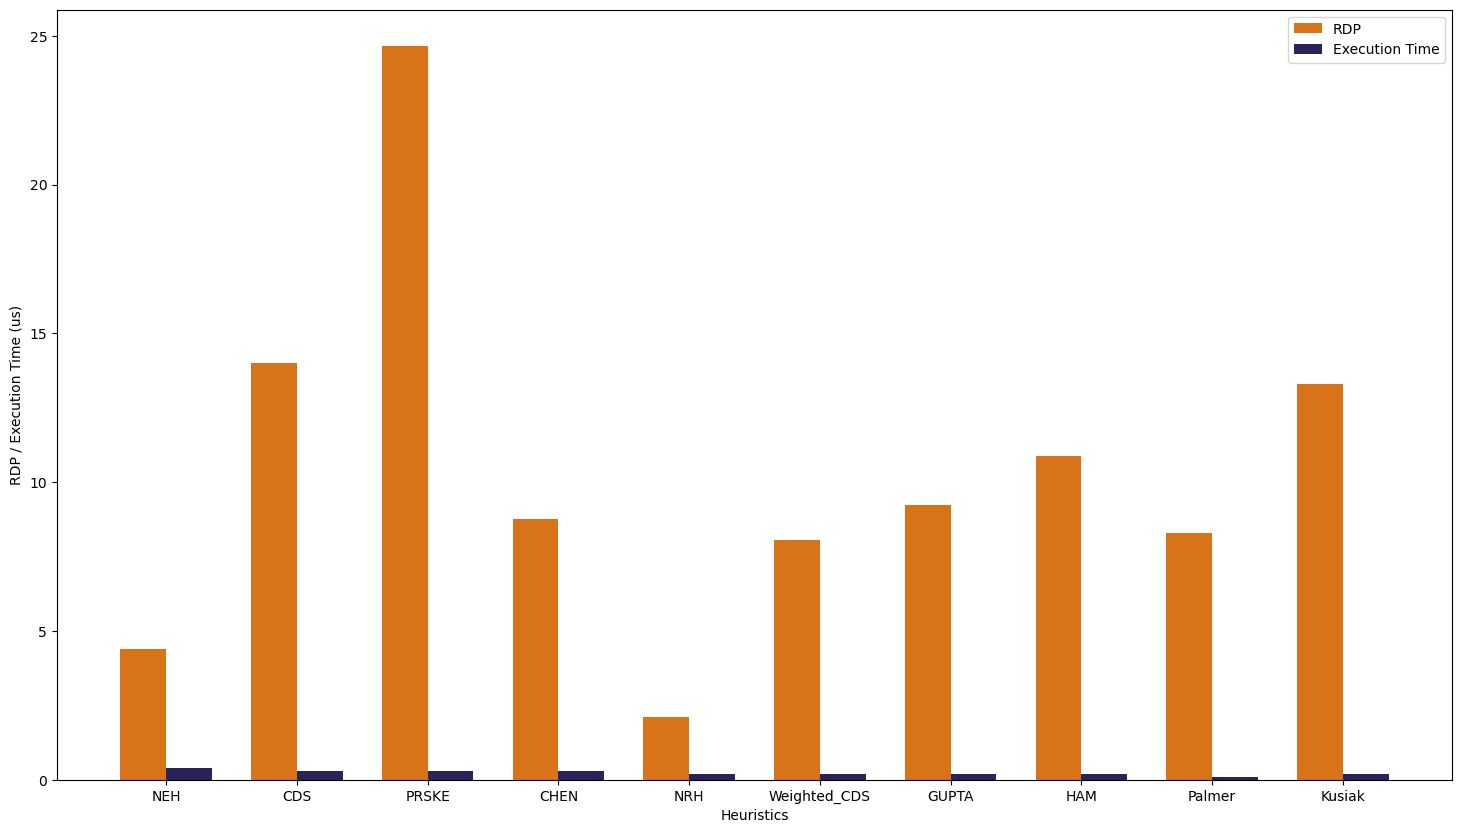

In [ ]:
var = run_all_algo(benchmarks[0], upper_bound[0])
generate_histogram(var)

### New Ramzi Heuristic  Explication

this is a description for the proposed heuristic

NRH is a modification of the NEH algorithm that changes the order in which jobs are considered for scheduling. Instead of simply summing up the processing times of each job, it multiplies each processing time by a quantity proportional to the index of the machine. This modification aims to prioritize jobs with shorter processing times on machines closer to the first machine, potentially reducing the total completion time of the schedule.

Here's how the modified heuristic works:

1. Processing Time Adjustment: For each job, instead of considering its raw processing time, you adjust it by multiplying it by a factor proportional to the index of the machine. The intuition behind this adjustment is to give higher priority to jobs with shorter processing times on machines that are closer to the beginning of the flow shop sequence.

$$\tilde{p}_{ij} = \frac{p(i, j)}{\exp(-\alpha \cdot j)}$$

where:
- j is the index of the machine
- $\alpha$: is a hyper parameter to control to which degree the order of the machine is important ($\alpha = 0$ in case of the pure NEH algorithm)

2. Sorting Jobs: Once you've adjusted the processing times for each job, you sort them based on these adjusted processing times. Jobs with shorter adjusted processing times will be considered earlier in the scheduling process.

3. Insertion Procedure: Similar to the NEH algorithm, you then use an insertion procedure to insert each job into the schedule. However, with this modification, the priority of jobs is determined based on their adjusted processing times, which take into account both the raw processing time and the proximity of the machine to the beginning of the sequence.

4. Iterative Improvement: As with the NEH algorithm, you may perform iterative improvement steps to refine the solution further. This could involve swapping or reordering jobs within the schedule based on the modified priority rule.

By considering the adjusted processing times that take into account the proximity of machines to the beginning of the flow shop sequence, this modified heuristic aims to potentially improve the efficiency of the scheduling process and produce schedules with shorter completion times. However, as with any heuristic approach, the effectiveness of this modification may vary depending on the specific characteristics of the scheduling problem at hand.